In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### import the library 


In [ ]:
import re  # Import the regular expressions module
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, 
    Bidirectional, SpatialDropout1D, LayerNormalization,
    GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# 1. Load and preprocess data


In [ ]:
# 1. Load and preprocess data
df = pd.read_csv('//kaggle/input/data-set/df_final0123.csv')
df = df.dropna(subset=['Commentaire', 'Statut'])

# Clean Algerian Arabic text
def clean_algerian_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Normalize elongated words
    text = re.sub(r'[^\w\sÀ-ÿ\u0600-\u06FF]', ' ', text)  # Keep Arabic/French chars
    return re.sub(r'\s+', ' ', text).strip().lower()

df['cleaned_text'] = df['Commentaire'].apply(clean_algerian_text)

# 2. Encode labels properly
le = LabelEncoder()
df['label'] = le.fit_transform(df['Statut'])  # Convert string labels to numeric
class_names = le.classes_

In [ ]:
# 3. Tokenization and sequence preparation
tokenizer = Tokenizer(
    num_words=20000,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=False
)
tokenizer.fit_on_texts(df['cleaned_text'])

vocab_size = len(tokenizer.word_index) + 1
max_len = 128  # Optimal for Algerian dialect

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# 4. Train-test split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,
    df['label'].values,  # Use numeric labels
    test_size=0.2,
    stratify=df['label'],
    random_state=42


In [ ]:
# 5. Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

In [52]:



# 6. Transformer + LSTM Model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_model(vocab_size, max_len):
    inputs = Input(shape=(max_len,))
    
    # Embedding layer
    x = Embedding(
        vocab_size, 
        256, 
        input_length=max_len, 
        mask_zero=True
    )(inputs)
    
    # Transformer
    x = TransformerBlock(256, 8, 512)(x)
    x = SpatialDropout1D(0.3)(x)
    
    # BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling1D()(x)
    
    # Classifier
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    return Model(inputs, outputs)

model = build_model(vocab_size, max_len)

# 7. Compile and train
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

# 8. Evaluation
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'transformer_block_11' (of type TransformerBlock) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


752/752 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - accuracy: 0.3515 - loss: 2.6825 - val_accuracy: 0.4462 - val_loss: 2.2815 - learning_rate: 3.0000e-05
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.4765 - loss: 2.1486 - val_accuracy: 0.6010 - val_loss: 1.7304 - learning_rate: 3.0000e-05
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.6369 - loss: 1.6281 - val_accuracy: 0.6743 - val_loss: 1.3793 - learning_rate: 3.0000e-05
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.7241 - loss: 1.2707 - val_accuracy: 0.7019 - val_loss: 1.1662 - learning_rate: 3.0000e-05
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.7693 - loss: 1.0198 - val_accuracy: 0.7174 - val_loss: 1.0339 - learning_rate: 3.0000e-05

Validation Accuracy: 0.7174
Validation Loss: 1.0339


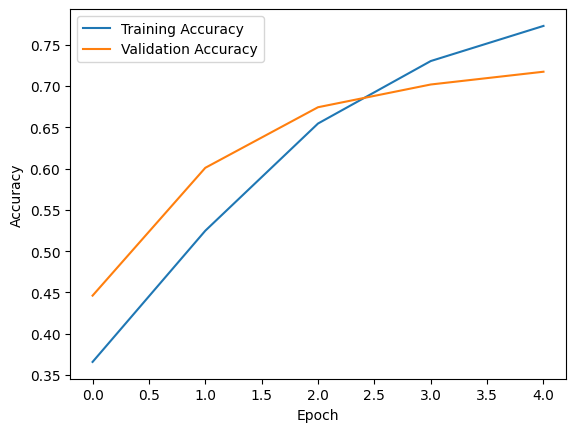

ValueError: Input 0 of layer "functional_13" is incompatible with the layer: expected shape=(None, 128), found shape=(None, 1000)

In [53]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')